Setting the params

In [1]:
# this code is based on [ref], which is released under the MIT licesne
# make sure you reference any code you have studied as above here

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# hyperparameters
batch_size  = 64
n_channels  = 3
latent_size = 512
dataset = 'cifar10'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(dataset)

cifar10


Hang the google drive

In [2]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Define a simple convolutional autoencoder**

In [ ]:
# simple block of convolution, batchnorm, and leakyrelu
class Block(nn.Module):
    def __init__(self, in_f, out_f):
        super(Block, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)

# define the model
class Autoencoder(nn.Module):
    def __init__(self, f=16):
        super().__init__()

        self.encode = nn.Sequential(
            Block(n_channels, f),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 16x16 (if cifar10, 48x48 if stl10)
            Block(f  ,f*2),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 8x8
            Block(f*2,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 4x4
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 2x2
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 1x1
            Block(f*4,latent_size)
        )

        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2), # output = 2x2
            Block(latent_size,f*4),
            nn.Upsample(scale_factor=2), # output = 4x4
            Block(f*4,f*4),
            nn.Upsample(scale_factor=2), # output = 8x8
            Block(f*4,f*2),
            nn.Upsample(scale_factor=2), # output = 16x16
            Block(f*2,f  ),
            nn.Upsample(scale_factor=2), # output = 32x32
            nn.Conv2d(f,n_channels, 3,1,1),
            nn.Sigmoid()
        )


    def rho_loss(self, data_rho, rho, size_average=True):
        self.data_rho = data_rho        
        dkl = - rho * torch.log(self.data_rho) - (1-rho)*torch.log(1-self.data_rho) # calculates KL divergence
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss

A = Autoencoder().to(device)
print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
optimiser = torch.optim.Adam(A.parameters(), lr=0.001)
epoch = 0


> Number of autoencoder parameters 750147


## **Load original dataset**

In [36]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

train_iterator = iter(cycle(train_loader))

Files already downloaded and verified


**Show the original dataset**

In [ ]:
# let's view some of the training data
# 分辨率 = 175
plt.rcParams['figure.dpi'] = 175
cat_list = []
# while(True):
for k in range(1):
  x,t = next(train_iterator)
  tags = t.numpy()
  sel = []
  for i in range(len(tags)):
    if tags[i] == 2 or tags[i] == 7:
      sel.append(i)
  x = x[sel]
  cat_list.append(x)
cat = torch.cat(cat_list)
print(cat.type(), cat)
x = cat.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

## **Main training loop**

In [31]:
# training loop, you will want to train for more than 10 here!
# rest images
cat_list = []
A.train()
while (epoch<100000):
    
    # array(s) for the performance measures
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    xx = 0
    # for i in range(1000):
    flag = False
    while(True):
        if xx == 100:
          break
        # sample x from the dataset
        x,t = next(train_iterator)
        tags = t.numpy()
        for i in range(len(tags)):
          if tags[i] == 7: # or tags[i] == 2:
            if len(cat_list) == batch_size:
              # print(len(cat_list))
              f = torch.cat(cat_list)
              xx += 1
              flag = True
              cat_list = []
            else:
              # print(x[i].shape)
              cat_list.append(x[i].unsqueeze(0))

        if flag:
          # print(f.shape)
          f = f.to(device)

          # do the forward pass with mean squared error
          # z = A.encode(f)
          # x_hat = A.decode(z)
          # loss = ((f-x_hat)**2).mean() # + rho_loss

          # this for the VAE model
          x_hat, mu, logvar = A(f)
          loss = loss_function(x_hat, f, mu, logvar)

          # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
          optimiser.zero_grad()
          loss.backward()
          nn.utils.clip_grad_norm_(A.parameters(), max_norm=20, norm_type=2)
          optimiser.step()

          # collect stats
          loss_arr = np.append(loss_arr, loss.item())
          flag = False

    # sample your model (autoencoders are not good at this)
    # z = torch.randn_like(z)
    z = torch.randn_like(torch.zeros((batch_size, latent_size, 1, 1))).cuda()
    # print(z.shape)
    g = A.decode(z)

    # plot some examples
    print('loss ' + str(loss.mean()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

    epoch = epoch+1

Output hidden; open in https://colab.research.google.com to view.

In [37]:
# training loop, you will want to train for more than 10 here!
# rest images
cat_list = []
A.train()
while (epoch<100000):
    
    # array(s) for the performance measures
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    xx = 0
    # for i in range(1000):
    flag = False
    while(True):
        if xx == 100:
          break
        # sample x from the dataset
        x,t = next(train_iterator)
        tags = t.numpy()
        for i in range(len(tags)):
          if tags[i] == 2 or tags[i] == 7:
            if len(cat_list) == batch_size:
              # print(len(cat_list))
              f = torch.cat(cat_list)
              xx += 1
              flag = True
              cat_list = []
            else:
              # print(x[i].shape)
              cat_list.append(x[i].unsqueeze(0))

        if flag:
          # print(f.shape)
          f = f.to(device)

          # do the forward pass with mean squared error
          # z = A.encode(f)
          # x_hat = A.decode(z)
          # loss = ((f-x_hat)**2).mean() # + rho_loss

          # this for the VAE model
          x_hat, mu, logvar = A(f)
          loss = loss_function(x_hat, f, mu, logvar)

          # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
          optimiser.zero_grad()
          loss.backward()
          nn.utils.clip_grad_norm_(A.parameters(), max_norm=20, norm_type=2)
          optimiser.step()

          # collect stats
          loss_arr = np.append(loss_arr, loss.item())
          flag = False

    # sample your model (autoencoders are not good at this)
    # z = torch.randn_like(z)
    z = torch.randn_like(torch.zeros((batch_size, latent_size, 1, 1))).cuda()
    # print(z.shape)
    g = A.decode(z)

    # plot some examples
    print('loss ' + str(loss.mean()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

    epoch = epoch+1

Output hidden; open in https://colab.research.google.com to view.

## **New DataSet**

In [23]:
import cv2
import os
from torch.utils.data import DataLoader,Dataset
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, item):
        return [self.data[item][0], self.data[item][1]], self.label[item]

    def __len__(self):
        return len(self.data)


path = 'drive/My Drive/training/processed/cifar/'
imgs = []
paths1 = os.listdir(path+"horse")
paths2 = os.listdir(path+"bird")
paths1.sort(key= lambda x:int(x[:-4]))
paths2.sort(key= lambda x:int(x[:-4]))
for i in range(51):
    mydata = cv2.imread(path+'horse/'+paths1[i]) /255.0
    mydata1 = cv2.imread(path+'bird/'+paths2[i]) /255.0
    image = [mydata,mydata1]
    imgs.append(image)

imgs = np.array(imgs).transpose(0,1,4,2,3)
imgs = torch.from_numpy(imgs)
print(imgs.type(), imgs.shape)
label = torch.zeros(len(imgs))
print(label.shape)


train_data = MyDataset(imgs, label)
train_loader = DataLoader(train_data, batch_size=batch_size)

train_iterator = iter(cycle(train_loader))
# img,t=next(train_iterator)
# print(img[0].shape)

torch.DoubleTensor torch.Size([51, 2, 3, 32, 32])
torch.Size([51])


In [ ]:
import cv2
import os
from torch.utils.data import DataLoader,TensorDataset
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


path = 'drive/My Drive/training/processed/cifar/bird'
imgs = []
paths = os.listdir(path)
for pt in paths:
    mydata = cv2.imread(path + "/{}".format(pt)) /255.0
    image = np.array(mydata)
    imgs.append(image)

imgs = np.array(imgs).transpose(0,3,1,2)
imgs = torch.from_numpy(imgs)
print(imgs.type())
label = torch.zeros(len(imgs))
print(label.shape)


train_data = TensorDataset(imgs, label)
train_loader = DataLoader(train_data, batch_size=batch_size)

In [22]:
# let's view some of the training data
# 分辨率 = 175
plt.rcParams['figure.dpi'] = 175
for i in range(5):
  img,t = next(train_iterator)
  x = img[1].float()
  x = x.to(device)
  plt.grid(False)
  plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **VAE Model**

In [15]:
# simple block of convolution, batchnorm, and leakyrelu
class Block(nn.Module):
    def __init__(self, in_f, out_f):
        super(Block, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)

def loss_function(recon_x, x, y, mu, logvar):
    """
    :param recon_x: generated image
    :param x: original image
    :param mu: latent mean of z
    :param logvar: latent log variance of z
    """
    BCE_loss = nn.BCELoss(reduction='sum')
    reconstruction_loss = BCE_loss(recon_x, x)*0.6 + BCE_loss(recon_x, y)*0.4
    KL_divergence = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mu**2)
    # print(reconstruction_loss, KL_divergence)

    return reconstruction_loss + KL_divergence


# define the model
class Autoencoder(nn.Module):
    def __init__(self, f=16):
        super().__init__()

        self.encode1 = nn.Sequential(
            Block(n_channels, f),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 16x16 (if cifar10, 48x48 if stl10)
            Block(f  ,f*2),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 8x8
            Block(f*2,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 4x4
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 2x2
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 1x1
            Block(f*4,latent_size),
            nn.Flatten()
        )

        self.encode2 = nn.Sequential(
            Block(n_channels, f),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 16x16 (if cifar10, 48x48 if stl10)
            Block(f  ,f*2),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 8x8
            Block(f*2,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 4x4
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 2x2
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 1x1
            Block(f*4,latent_size),
            nn.Flatten()
        )

        self.fc2_mean = nn.Linear(2*latent_size, latent_size)
        self.fc2_logvar = nn.Linear(2*latent_size, latent_size)

        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2), # output = 2x2
            Block(latent_size,f*4),
            nn.Upsample(scale_factor=2), # output = 4x4
            Block(f*4,f*4),
            nn.Upsample(scale_factor=2), # output = 8x8
            Block(f*4,f*2),
            nn.Upsample(scale_factor=2), # output = 16x16
            Block(f*2,f  ),
            nn.Upsample(scale_factor=2), # output = 32x32
            nn.Conv2d(f,n_channels, 3,1,1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
      z_h1 = self.encode1(x)
      z_h2 = self.encode2(y)
      z_h = torch.cat([z_h1,z_h2],dim=1)
      # print(z_h.shape)
      self.mu = self.fc2_mean(z_h)
      self.logvar = self.fc2_logvar(z_h)
      std = 0.5 * torch.exp(self.logvar)
      # std = std.to(device)
      # self.mu = self.mu.to(device)
        # N(mu, std^2) = N(0, 1) * std + mu
      z = torch.randn(std.size()).cuda() * std + self.mu
      z = z.unsqueeze(-1).unsqueeze(-1)
      # print(z.shape)
      z = z.to(device)
      return self.decode(z), self.mu, self.logvar


A = Autoencoder().to(device)
print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
optimiser = torch.optim.Adam(A.parameters(), lr=0.0001)

> Number of autoencoder parameters 2194115


## **Train loop for new dataset**



In [24]:
# training loop, you will want to train for more than 10 here!
# rest images
epoch = 0
train_iterator = iter(cycle(train_loader))
while (epoch<1000):
    # print(epoch)
    
    # array(s) for the performance measures
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(100):

        img,t = next(train_iterator)
        x = img[0].float()
        y = img[1].float()

        x = x.to(device)
        y = y.to(device)

        # do the forward pass with mean squared error
        # z = A.encode(x)
        # x_hat = A.decode(z)
        # loss = ((x-x_hat)**2).mean() # + rho_loss

        # this for the VAE model
        x_hat, mu, logvar = A(x,y)
        loss = loss_function(x_hat, x, y, mu, logvar)

        # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
        optimiser.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(A.parameters(), max_norm=20, norm_type=2)
        optimiser.step()

        # collect stats
        loss_arr = np.append(loss_arr, loss.item())

    # sample your model (autoencoders are not good at this)
    # z = torch.randn_like(z)
    z = torch.randn_like(torch.zeros((batch_size, latent_size, 1, 1))).cuda()
    g = A.decode(z)

    # plot some examples
    print('loss ' + str(loss.mean()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

    epoch = epoch+1

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# optional example code to save your training progress for resuming later if you authenticated Google Drive previously
torch.save({'A':A.state_dict(), 'optimiser':optimiser.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')

In [26]:
# optional example to resume training if you authenticated Google Drive previously
params = torch.load('drive/My Drive/training/save.chkpt')
A.load_state_dict(params['A'])
optimiser.load_state_dict(params['optimiser'])
epoch = params['epoch']

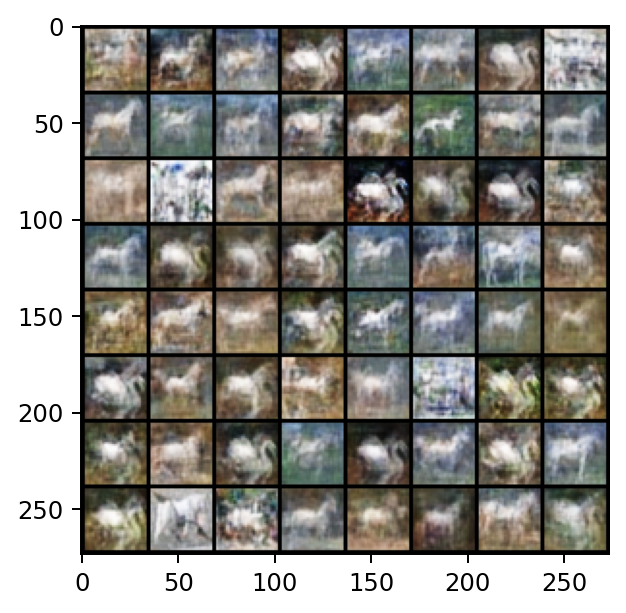

In [27]:
# now show your best batch of data for the submission, right click and save the image for your report
z = torch.randn_like(torch.zeros((batch_size, latent_size, 1, 1))).cuda()
g = A.decode(z)
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()